# eda007

In [1]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
import itertools

import pandas as pd
import numpy as np

In [2]:
@dataclass
class Cfg:
    exp_name = "eda001"
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")
cfg = Cfg()

In [3]:
train = pd.read_csv(cfg.input_dir + "train.csv")
labels = pd.read_csv(cfg.input_dir + "train_labels.csv")
test = pd.read_csv(cfg.input_dir + "test.csv")
sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")

In [7]:
train["fqid"].unique().tolist()

['intro',
 'gramps',
 'teddy',
 'photo',
 nan,
 'notebook',
 'retirement_letter',
 'tobasement',
 'janitor',
 'toentry',
 'groupconvo',
 'report',
 'boss',
 'wells',
 'directory',
 'tocollection',
 'cs',
 'tunic',
 'tunic.hub.slip',
 'tostacks',
 'outtolunch',
 'tocloset',
 'tomap',
 'tunic.historicalsociety',
 'tunic.kohlcenter',
 'plaque',
 'plaque.face.date',
 'togrampa',
 'tunic.capitol_0',
 'chap1_finale',
 'chap1_finale_c',
 'tocloset_dirty',
 'what_happened',
 'trigger_scarf',
 'trigger_coffee',
 'tunic.capitol_1',
 'tofrontdesk',
 'archivist',
 'magnify',
 'tunic.humanecology',
 'worker',
 'businesscards',
 'businesscards.card_0.next',
 'businesscards.card_1.next',
 'businesscards.card_bingo.next',
 'businesscards.card_bingo.bingo',
 'tohallway',
 'tunic.drycleaner',
 'logbook',
 'logbook.page.bingo',
 'tunic.library',
 'tomicrofiche',
 'reader',
 'reader.paper0.next',
 'reader.paper1.next',
 'reader.paper2.bingo',
 'wellsbadge',
 'journals',
 'journals.hub.topics',
 'journals.

In [8]:
train["room_fqid"].unique().tolist()

['tunic.historicalsociety.closet',
 'tunic.historicalsociety.basement',
 'tunic.historicalsociety.entry',
 'tunic.historicalsociety.collection',
 'tunic.historicalsociety.stacks',
 'tunic.kohlcenter.halloffame',
 'tunic.capitol_0.hall',
 'tunic.historicalsociety.closet_dirty',
 'tunic.historicalsociety.frontdesk',
 'tunic.humanecology.frontdesk',
 'tunic.drycleaner.frontdesk',
 'tunic.library.frontdesk',
 'tunic.library.microfiche',
 'tunic.capitol_1.hall',
 'tunic.historicalsociety.cage',
 'tunic.historicalsociety.collection_flag',
 'tunic.wildlife.center',
 'tunic.flaghouse.entry',
 'tunic.capitol_2.hall']

In [9]:
train["text_fqid"].unique().tolist()

['tunic.historicalsociety.closet.intro',
 'tunic.historicalsociety.closet.gramps.intro_0_cs_0',
 'tunic.historicalsociety.closet.teddy.intro_0_cs_0',
 nan,
 'tunic.historicalsociety.closet.teddy.intro_0_cs_5',
 'tunic.historicalsociety.closet.photo',
 'tunic.historicalsociety.closet.notebook',
 'tunic.historicalsociety.closet.retirement_letter.hub',
 'tunic.historicalsociety.basement.janitor',
 'tunic.historicalsociety.entry.groupconvo',
 'tunic.historicalsociety.entry.boss.talktogramps',
 'tunic.historicalsociety.entry.wells.talktogramps',
 'tunic.historicalsociety.collection.cs',
 'tunic.historicalsociety.collection.tunic.slip',
 'tunic.historicalsociety.collection.gramps.found',
 'tunic.historicalsociety.stacks.outtolunch',
 'tunic.kohlcenter.halloffame.plaque.face.date',
 'tunic.kohlcenter.halloffame.togrampa',
 'tunic.capitol_0.hall.boss.talktogramps',
 'tunic.historicalsociety.closet_dirty.what_happened',
 'tunic.historicalsociety.closet_dirty.gramps.helpclean',
 'tunic.historica

In [10]:
train.nunique()

session_id          11779
index               20348
elapsed_time      3804019
event_name             11
name                    6
level                  23
page                    7
room_coor_x       9120274
room_coor_y       7047316
screen_coor_x       35331
screen_coor_y       56858
hover_duration      19474
text                  594
fqid                  127
room_fqid              19
text_fqid             126
fullscreen              0
hq                      0
music                   0
level_group             3
dtype: int64

In [6]:
def transform_labels_df(labels_):
    """
    labelsデータを整形する
    """
    labels = labels_.copy()
    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
    
    # trainの特徴量と結合するためにquestionに対応するlabel_groupを列として設けておく
    labels["level_group"] = ""
    labels.loc[labels["question"]<=3, "level_group"] = "0-4"
    labels.loc[(labels["question"]>=4)&(labels["question"]<=13), "level_group"] = "5-12"
    labels.loc[labels["question"]>=14, "level_group"] = "13-22"

    return labels

In [7]:
labels = transform_labels_df(labels)

In [9]:
labels_agg = labels.groupby("session_id")["correct"].sum().reset_index()

In [16]:
labels_agg[labels_agg["correct"]==18]

,session_id,correct
169,20100207584362790,18
173,20100208332760820,18
183,20100209120881110,18
325,20100313142799820,18
417,20100411443529630,18
...,...,...
11459,22080510120404790,18
11549,22090107194369204,18
11570,22090113012310444,18
11715,22090519421841530,18


In [12]:
labels_agg[labels_agg["correct"]==0]

,session_id,correct


<AxesSubplot: >

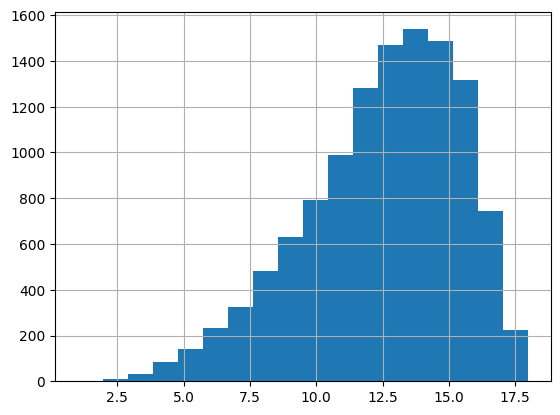

In [18]:
labels_agg["correct"].hist(bins=18)

In [5]:
train.dropna(subset=["hover_duration"])

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
49,20090312431273200,49,52328,object_hover,basic,1,NaN,NaN,NaN,NaN,NaN,7899.0,NaN,groupconvo,tunic.historicalsociety.entry,NaN,NaN,NaN,NaN,0-4
82,20090312431273200,82,87242,object_hover,basic,2,NaN,NaN,NaN,NaN,NaN,400.0,NaN,tunic,tunic.historicalsociety.collection,NaN,NaN,NaN,NaN,0-4
87,20090312431273200,87,92242,object_hover,undefined,2,NaN,NaN,NaN,NaN,NaN,3949.0,NaN,tunic.hub.slip,tunic.historicalsociety.collection,NaN,NaN,NaN,NaN,0-4
127,20090312431273200,127,135124,map_hover,basic,3,NaN,NaN,NaN,NaN,NaN,234.0,NaN,tunic.historicalsociety,tunic.historicalsociety.entry,NaN,NaN,NaN,NaN,0-4
128,20090312431273200,128,135256,map_hover,basic,3,NaN,NaN,NaN,NaN,NaN,17.0,NaN,tunic.kohlcenter,tunic.historicalsociety.entry,NaN,NaN,NaN,NaN,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13174191,22100221145014656,1585,5447168,object_hover,undefined,21,NaN,NaN,NaN,NaN,NaN,99.0,NaN,journals_flag.pic_2.next,tunic.historicalsociety.stacks,NaN,NaN,NaN,NaN,13-22
13174193,22100221145014656,1587,5448152,object_hover,undefined,21,NaN,NaN,NaN,NaN,NaN,565.0,NaN,journals_flag.pic_2.next,tunic.historicalsociety.stacks,NaN,NaN,NaN,NaN,13-22
13174194,22100221145014656,1588,5466868,object_hover,undefined,21,NaN,NaN,NaN,NaN,NaN,150.0,NaN,journals_flag.pic_0.next,tunic.historicalsociety.stacks,NaN,NaN,NaN,NaN,13-22
13174203,22100221145014656,1597,5482022,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,1200.0,NaN,tomap,tunic.historicalsociety.entry,NaN,NaN,NaN,NaN,13-22
